
Made by: Andrei Kulchyk (155489) and Fiodar Piatrovich (155174)

[Github](https://github.com/aaakulchyk/put-evolutionary-computations)

# Description of a problem

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.

The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path

from joblib import Parallel, delayed
from time import perf_counter

import numpy as np
import pandas as pd

from hamiltonian_cycle.experiment import perform_experiment
from hamiltonian_cycle.algorithms.lab6 import (
    MultipleStartLocalSearch,
    IteratedLocalSearch,
)
from hamiltonian_cycle.algorithms.lab1 import init_random_solution
from hamiltonian_cycle.plots import plot_solution
from hamiltonian_cycle.costs import dm, function_cost

from time import perf_counter

In [3]:
def read_dataset_csv(csv_path: Path) -> pd.DataFrame:
    return pd.read_csv(csv_path, sep=";", names=["x", "y", "cost"])


DATA_DIR = Path("../data").resolve()

ds_a = read_dataset_csv(DATA_DIR / "TSPA.csv")
ds_b = read_dataset_csv(DATA_DIR / "TSPB.csv")

dm_a = dm(ds_a)
dm_b = dm(ds_b)

# MSLS

In [4]:
class MSLSMetrics:
    def __init__(self, solution: pd.DataFrame, execution_time: float):
        self.cost = function_cost(solution)
        self.solution = list(solution.index)
        self.execution_time = execution_time


def run_msls(msls: MultipleStartLocalSearch) -> MSLSMetrics:
    start_time = perf_counter()
    mlsm_solution = msls()
    end_time = perf_counter()
    execution_time = end_time - start_time
    return MSLSMetrics(mlsm_solution, execution_time)

#### Results on Dataset A

Best solution: [158, 53, 100, 26, 97, 152, 1, 101, 86, 75, 2, 129, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 57, 55, 52, 185, 119, 40, 81, 90, 27, 165, 106, 178, 3, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 34, 48, 54, 177, 4, 112, 84, 35, 184, 160, 42, 43, 116, 65, 131, 149, 59, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180]
Objective function statistics:
minimum.cost = 70662
mean = 71267.4
maximum.cost= 71693


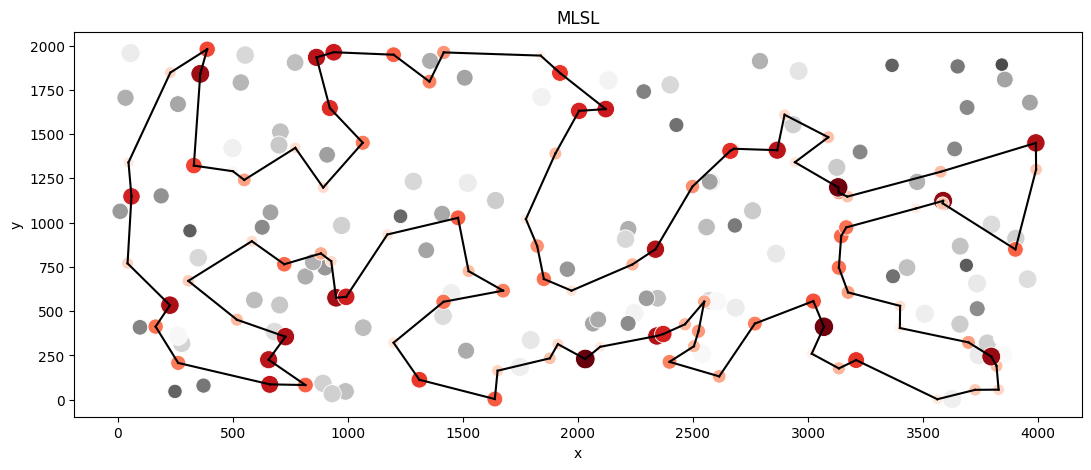

In [5]:
msls_runs = 20
msls_iterations = 200

msls = MultipleStartLocalSearch(ds=ds_a, dm=dm_a, iterations=msls_iterations)


metrics: list[MSLSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_msls)(msls) for _ in range(msls_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)

print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
plot_solution(ds_a, minimum.solution, title="MLSL")

#### Results on Dataset B

In [ ]:
msls_runs = 20
msls_iterations = 200

msls = MultipleStartLocalSearch(ds=ds_b, dm=dm_b, iterations=msls_iterations)


metrics: list[MSLSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_msls)(msls) for _ in range(msls_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)

Best solution: [11, 182, 138, 33, 160, 29, 0, 109, 35, 143, 159, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 148, 47, 94, 66, 172, 179, 185, 95, 86, 166, 194, 176, 180, 113, 103, 114, 137, 127, 89, 163, 165, 187, 153, 81, 77, 111, 104, 8, 82, 21, 141, 61, 36, 177, 5, 45, 142, 78, 175, 80, 190, 136, 73, 164, 54, 31, 193, 117, 198, 1, 135, 102, 63, 100, 40, 107, 10, 133, 122, 131, 112, 121, 51, 90, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139]
Objective function statistics:
minimum.cost = 45321
mean = 45751.25
maximum.cost= 46137


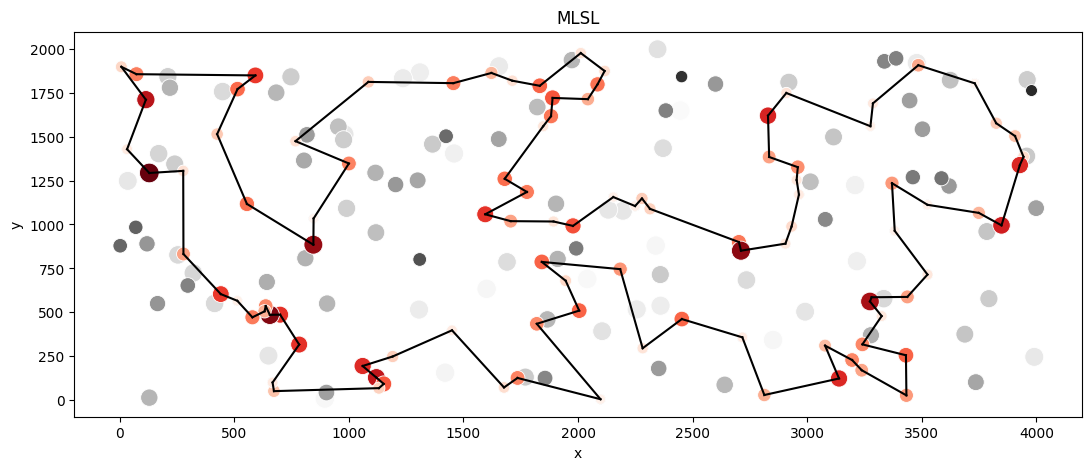

In [ ]:
print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
plot_solution(ds_b, minimum.solution, title="MLSL,")

## ILS

$$
\begin{aligned}
&\textbf{Algorithm: Iterated Local Search (ILS)} \\[6pt]

&\textbf{Input: } \text{time\_budget} \\
&\textbf{Output: } \text{Best solution found} \\[12pt]

&\text{1. } s \leftarrow \text{GenerateRandomSolution()} \\
&\text{2. } s \leftarrow \text{LocalSearch}(s) \\
&\text{3. } s_{best} \leftarrow s \\[6pt]

&\text{4. While } time\_elapsed < \text{time\_budget:} \\
&\quad 4.1.\ s' \leftarrow \text{Perturb}(s) \\
&\quad 4.2.\ s' \leftarrow \text{LocalSearch}(s') \\
&\quad 4.3.\ \textbf{if } \text{Accept}(s', s) \textbf{ then } s \leftarrow s' \\
&\quad 4.4.\ \textbf{if } f(s) < f(s_{best}) \textbf{ then } s_{best} \leftarrow s \\[6pt]

&\textbf{Return } s_{best}
\end{aligned}
$$

The *double bridge* move is an essential tool in optimization for problems where solutions are permutations. It is effective because:

1. It makes large structural changes that help escape local optima.
2. It is computationally simple and easy to implement.
3. It complements local search, creating a balance between exploration and exploitation.
4. It has proven successful in theoretical and practical studies:
    * [Lin-Kernighan Heuristic Adaptations for the Generalized Traveling Salesman Problem](https://www.researchgate.net/publication/227414913_Lin-Kernighan_Heuristic_Adaptations_for_the_Generalized_Traveling_Salesman_Problem)
    * [Iterated Local Search
](https://www.researchgate.net/publication/23695291_Iterated_Local_Search)

While **Node external insertion (exchange)** applied on top, serves as a complementary permutation, removing 5% of internal nodes and adding the same amount of external ones to escape from solution stagnation (statis)

$$
\begin{aligned}
&\textbf{Procedure: Perturb}(s, \text{selected\_nodes}, \text{non\_selected\_nodes}, \text{n\_insertions}) \\[6pt]
&\text{Input: } s \text{ (a solution)}, \text{selected\_nodes}, \text{non\_selected\_nodes}, \text{n\_insertions}\\
&\text{Output: } s' \text{ (a perturbed solution)} \\[12pt]

&\underline{\text{Double-Bridge Perturbation:}} \\
&\quad 1.\ \text{Let } n = \text{length}(s) \\
&\quad 2.\ \text{Select four distinct positions } i,j,k,l \text{ with } 1 < i < j < k < l < n \\
&\quad 3.\ \text{segment1} \leftarrow s[1 \dots i-1] \\
&\quad 4.\ \text{segment2} \leftarrow s[i \dots j-1] \\
&\quad 5.\ \text{segment3} \leftarrow s[j \dots k-1] \\
&\quad 6.\ \text{segment4} \leftarrow s[k \dots l-1] \\
&\quad 7.\ \text{segment5} \leftarrow s[l \dots n] \\
&\quad 8.\ s' \leftarrow \text{Concatenate}(\text{segment1}, \text{segment3}, \text{segment2}, \text{segment4}, \text{segment5}) \\[12pt]

&\underline{\text{Node Insertion Perturbation:}} \\
&\quad 1.\ \text{Choose a node } a \in \text{selected\_nodes} \\
&\quad 2.\ \text{Remove } a \text{ from } s \text{ and from } \text{selected\_nodes} \\
&\quad 3.\ \text{Choose a node } b \in \text{non\_selected\_nodes} \\
&\quad 4.\ \text{Insert } b \text{ into a new position in } s \\
&\quad 5.\ \text{Update selected and non-selected nodes} \\
&\quad 6.\ s' \leftarrow s \\
&\quad 7.\ \text{Repeat n\_insertions times} \\[12pt]

&\textbf{Return } s'
\end{aligned}
$$

#### Results on Dataset A

In [31]:
class ILSMetrics:
    def __init__(
        self,
        solution: pd.DataFrame,
        n_executions: float,
        num_sucessfull_perturbations: int,
    ):
        self.cost = function_cost(solution)
        self.solution = list(solution.index)
        self.n_executions = n_executions
        self.num_sucessfull_perturbations = num_sucessfull_perturbations


def run_ils(ils: IteratedLocalSearch) -> ILSMetrics:
    best_solution, num_local_searches, num_sucessfull_perturbations = ils()
    return ILSMetrics(best_solution, num_local_searches, num_sucessfull_perturbations)

In [32]:
ils_runs = 20
msls_iterations = 200
time_budget_sec = 11 * msls_iterations
ils = IteratedLocalSearch(ds=ds_a, dm=dm_a, max_runtime=time_budget_sec)


metrics: list[ILSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_ils)(ils) for _ in range(ils_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)
mean_n_iterations = sum([metric.n_executions for metric in metrics]) / len(metrics)
mean_n_sucessfull_perturbations = sum(
    [metric.num_sucessfull_perturbations for metric in metrics]
) / len(metrics)

Best solution: [171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 115, 46, 68, 139, 41, 193, 159, 181, 42, 43, 116, 65, 149, 131, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 57, 129, 92, 179, 185, 40, 119, 165, 90, 81, 196, 145, 78, 31, 56, 113, 175]
Objective function statistics:
minimum.cost = 69107
mean = 69326.15
maximum.cost= 69765
Mean Number of iterations: 1106.2
Mean Number of sucessfull perturbations: 1106.2


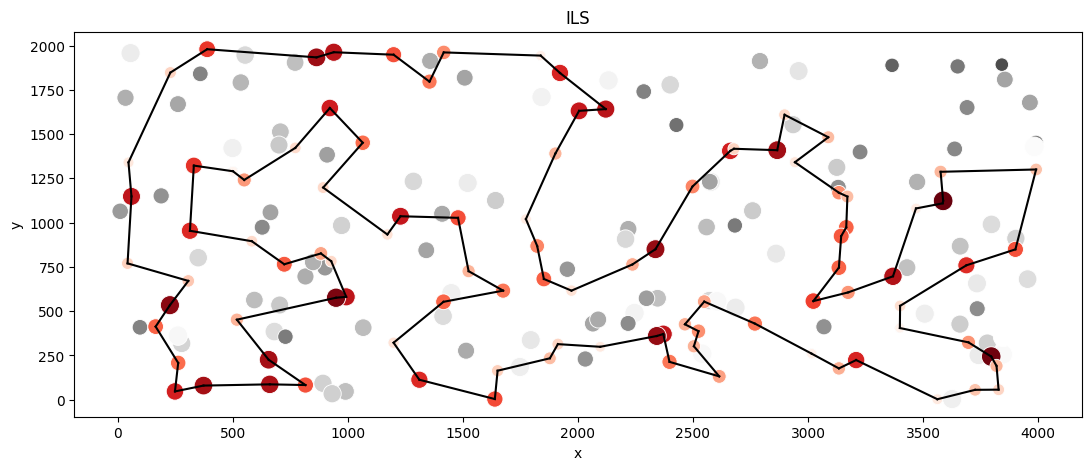

In [33]:
print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
print(f"Mean Number of iterations: {mean_n_iterations}")
print(f"Mean Number of sucessfull perturbations: {mean_n_iterations}")
plot_solution(ds_a, minimum.solution, title="ILS")

In [ ]:
#### Results on Dataset B

In [34]:
ils = IteratedLocalSearch(ds=ds_b, dm=dm_b, max_runtime=time_budget_sec)


metrics: list[ILSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_ils)(ils) for _ in range(ils_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)
mean_n_iterations = sum([metric.n_executions for metric in metrics]) / len(metrics)
mean_n_sucessfull_perturbations = sum(
    [metric.num_sucessfull_perturbations for metric in metrics]
) / len(metrics)

Best solution: [77, 141, 91, 61, 36, 177, 5, 78, 175, 142, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 63, 40, 107, 133, 122, 135, 131, 121, 51, 90, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139, 11, 138, 33, 160, 144, 104, 8, 82, 111, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 99, 130, 95, 185, 86, 166, 194, 176, 113, 114, 137, 127, 89, 103, 163, 187, 153, 81]
Objective function statistics:
minimum.cost = 43462
mean = 43765.6
maximum.cost= 44149
Mean Number of perturbations: 1114.8


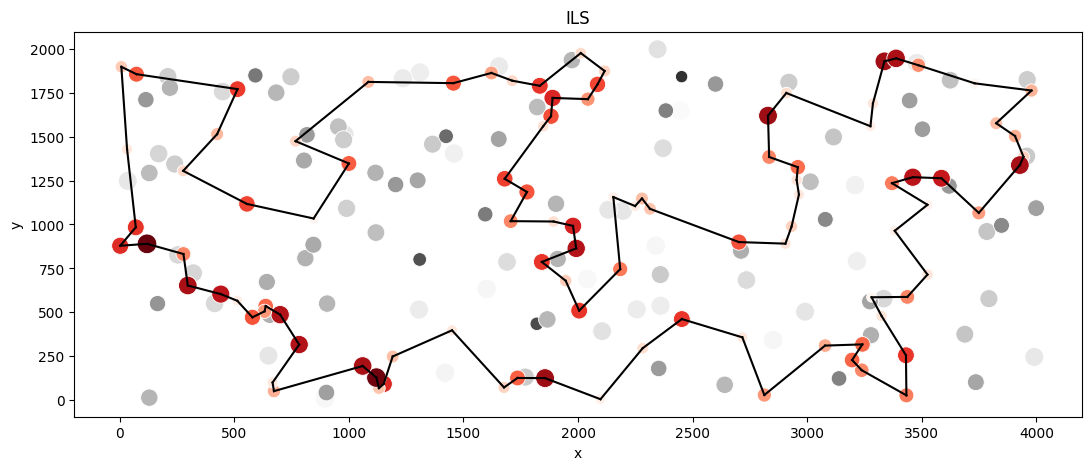

In [35]:
print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
print(f"Mean Number of perturbations: {mean_n_iterations}")
plot_solution(ds_b, minimum.solution, title="ILS")

# Summary

In [ ]:
a_res = pd.DataFrame(
    {
        "Steepest edge LS": [72046, 74033.715, 78801, 9.54, np.nan],
        "MLSM": [70662, 71267.4, 71693, 2223, np.nan],
        "ILS": [69107, 69326.15, 69765, 2223, 1106.2],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset A", "min"),
            ("Dataset A", "mean"),
            ("Dataset A", "max"),
            ("Dataset A", "seconds/iter"),
            ("Dataset A", "perturbations applied"),
        ]
    ),
).T

b_res = pd.DataFrame(
    {
        "Steepest edge LS": [45393, 48264.78, 50697, 9.02, np.nan],
        "MLSM": [45321, 45751.25, 4613, 2218, np.nan],
        "ILS": [43493, 43783.05, 44312, 2218, 1114.8],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset B", "min"),
            ("Dataset B", "mean"),
            ("Dataset B", "max"),
            ("Dataset B", "seconds/iter"),
            ("Dataset B", "perturbations applied"),
        ]
    ),
).T

minimum.cost = 69107
mean = 69326.15
maximum.cost = 69765

a_res.join(b_res).sort_values(by=("Dataset A", "mean"))

Dataset A                                   \
                       min       mean      max seconds/iter   
ILS                69107.0  69326.150  69765.0      2223.00   
MLSM               70662.0  71267.400  71693.0      2223.00   
Steepest edge LS   72046.0  74033.715  78801.0         9.54   

                                       Dataset B                     \
                 perturbations applied       min      mean      max   
ILS                             1106.2   43493.0  43783.05  44312.0   
MLSM                               NaN   45321.0  45751.25   4613.0   
Steepest edge LS                   NaN   45393.0  48264.78  50697.0   

                                                     
                 seconds/iter perturbations applied  
ILS                   2218.00                1114.8  
MLSM                  2218.00                   NaN  
Steepest edge LS         9.02                   NaN

# Conclusion

Due to choosing reasonable and academically prooved perturbations, we achieved results with `ILS` in same time budget better than on `MLSM`